In [45]:
"""
Implementation of a Resnet-18 model for classification of rooftop materials in Washington, D.C. from PlanetScope Imagery

"""

import os, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torchsat.models.classification import resnet18

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree

from fiona.crs import from_epsg

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

plt.ion() # interactive

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-materials/'

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [2]:
class RoofImageDataset_Planet(Dataset):
    """Class to handle PlanetScope SuperDove imagery for Resnet-18"""

    def __init__(self, gdf, img_path, imgdim=224, transform=None):
        """
        Args:
            gdf: Geodataframe containing 'geometry' column and 'class_code' column
            img_path: the path to the PlanetScope SuperDove composite image (single mosaic file)
                - see 'psscene-prep.py' for spectral indices calculation
            imgdim (int): Image dimension for CNN implementation
            transform (callable, optional): Optional transform to be applied on a sample

        Returns 
        """

        if not os.path.exists(img_path):
            raise ValueError(f'Image does not exists: {img_path}')

        self.geometries = [p.centroid for p in gdf.geometry.values]
        self.img = img_path
        self.image_dim = imgdim # resnet window dimension, defaults to 224
        self.Y = gdf.code.values
        self.transform = transform

        # Define transforms
        transform = transforms.Compose([
            transforms.Resize((self.image_dim, self.image_dim)),  # Resize to NxN for ResNet-18
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.geometries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Sample the PlanetScope image
        left, bottom, right, top = self.geometries[idx].bounds
        geom = self.geometries[idx]

        try:
            sample = self.sample_image(geom) # run the sampling function
            cc = self.Y[idx] # get the class codes

            # print(f'Array shape: {sample.shape}')
        
        except Exception as e:
            raise ValueError(e)

        # Convert the sample array to a Torch object
        sample = torch.from_numpy(sample)

        return {'image': sample.type(torch.FloatTensor),
                'code': torch.tensor(cc).type(torch.LongTensor)}

    
    def sample_image(self, geom):
        # Sample the image at each geometry
        samples = [] # store the samples in a list
        left, bottom, right, top = geom.bounds 

        N = self.image_dim
            
        # Use the windows.from_bounds() method to return the window
        # Returns image chunks from training data locations
        with rio.open(self.img) as src:

            # Define the number of bands in the image dim
            nbands = src.count
                            
            # Get pixel coordinates from map coordinates
            py, px = src.index(geom.x, geom.y)

            # Build an NxN window
            window = rio.windows.Window(px - N//2, py - N//2, N, N)

            # Read the data in the window
            # clip is a nbands * N * N numpy array
            sample = src.read(window=window)
            # print(f'Training sample shape: {sample.shape}')

            # Clear up some memory 
            del py, px, N, window

            samples.append(sample) # append results to the list

        # Convert the image chunk to a numpy array
        samples_arr = np.array(samples)

        del samples # Clear up memory

        # Make sure there is valid data
        if samples_arr.sum() > 0:
            ans = np.ma.masked_equal(samples_arr, 0).mean(axis=0)
        else:
            ans = samples_arr.mean(axis=0)

        del samples_arr

        return ans
        

# Return a quality batch if 255 detected in samples
def make_good_batch(batch):
    
    """
    Removes bad sample if 255 detected in class labels
    
    batch: dictionary containing 'image' tensor and 'class_code' tensor
    
    returns: dictionary same as input with class_code==255 removed from class_code 
             and corresponding image tensor removed
    """

    
    # Check for 255 in class codes
    valid_idx = torch.where(batch['code'] != 255)[0]

    # Check for NaN or Inf in class codes
    valid_idx = valid_idx[~torch.isnan(batch['code'][valid_idx])]
    valid_idx = valid_idx[~torch.isinf(batch['code'][valid_idx])]

    # Check for NaN or Inf in images
    valid_image_idx = []
    for idx in valid_idx:
        if not torch.isnan(batch['image'][idx]).any() and not torch.isinf(batch['image'][idx]).any():
            valid_image_idx.append(idx)
    
    valid_image_idx = torch.tensor(valid_image_idx, dtype=torch.long)

    new_batch = {}
    new_batch['image'] = batch['image'][valid_image_idx]
    new_batch['code'] = batch['code'][valid_image_idx]

    del valid_idx, valid_image_idx
    
    return new_batch


# Apply a minimum distance sample to training data
def min_dist_sample(gdf, min_distance):
    """
    Filters the GeoDataFrame to ensure samples are at least min_distance apart.

    Args:
        gdf: GeoDataFrame containing 'geometry' column.
        min_distance: Minimum distance between samples in the same units as the geometry.

    Returns:
        Filtered GeoDataFrame.
    """
    coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])
    tree = KDTree(coords)
    indices_to_keep = set(range(len(gdf)))

    for i in range(len(gdf)):
        if i not in indices_to_keep:
            continue
        indices = tree.query_radius([coords[i]], r=min_distance)[0]
        for index in indices:
            if index != i:
                indices_to_keep.discard(index)

    del coords, tree, indices

    return gdf.iloc[list(indices_to_keep)]


def print_raster(raster,open_file):
    """
    :param raster: input raster file
    :param open_file: should the file be opened or not
    :return: print statement with raster information
    """
    if open_file is True:
        img = rxr.open_rasterio(raster,masked=True).squeeze()
    else:
        img = raster
    print(
        f"shape: {img.rio.shape}\n"
        f"resolution: {img.rio.resolution()}\n"
        f"bounds: {img.rio.bounds()}\n"
        f"sum: {img.sum().item()}\n"
        f"CRS: {img.rio.crs}\n"
        f"NoData: {img.rio.nodata}"
        f"Array: {img}"
    )
    del img

print("Class and functions ready to use!")

Class and functions ready to use!


In [3]:
# Load the training data (footprints)
gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
footprints = gpd.read_file(gdf_path)
footprints.head()

,class_code,areaUTMsqft,uid,description,code,geometry
0,CS,357.783709,1CS,Composition Shingle,0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,CS,918.640862,2CS,Composition Shingle,0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,CS,1383.414170,3CS,Composition Shingle,0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,CS,836.410297,4CS,Composition Shingle,0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,CS,330.514264,5CS,Composition Shingle,0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [4]:
# Calculate the 'optimal' window size from the footprint areas
mean_area_sqft = int(footprints.areaUTMsqft.values.mean())
pct90_area_sqft = np.percentile(footprints.areaUTMsqft, 90)
print(f'Mean footprint area (sqft): {mean_area_sqft}')
print(f'90th percentile footprint area (sqft): {pct90_area_sqft}')

# Convert sqft to sqm
pct90_area_sqm = pct90_area_sqft * 0.092903

# Calculate the side length ('optimal' window size)
window_size = int(np.sqrt(pct90_area_sqm))
print(f'Optimal window size: {window_size}')

Mean footprint area (sqft): 1071
90th percentile footprint area (sqft): 1702.1315214770702
Optimal window size: 12


In [5]:
# Observe the class imbalance
footprints.class_code.value_counts()

class_code
ME    29651
CS    27687
SL    11080
UR     1018
WS      866
TL      617
SH      589
Name: count, dtype: int64

In [6]:
# Filter samples with a minimum distance of 10-meters
footprints_sp = min_dist_sample(footprints, 10)
footprints_sp.class_code.value_counts()

del footprints

class_code
CS    23004
ME    15562
SL    10109
WS      683
TL      532
SH      431
UR      383
Name: count, dtype: int64

In [7]:
# Filter out samples that are obscured by tree cover

# Load the reference samples (with image information calculated)
ref = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_sampled.gpkg')
ref = gpd.read_file(ref)
ref = ref[['uid','ndre']]

# Join to the footprint data by unique ID
footprints_sp_vg = footprints_sp.merge(ref, on='uid', how='left')
print(footprints_sp_vg.head())

# Filter out samples with NDRE > 0.42 (likely vegetation)
footprints_sp_vg = footprints_sp_vg[footprints_sp_vg['ndre'] < 0.42]
print("~~~~~~~~~~~~~~~~~")
print(footprints_sp_vg.class_code.value_counts())

del ref, footprints_sp

  class_code  areaUTMsqft  uid          description  code  \
0         CS   357.783709  1CS  Composition Shingle     0   
1         CS   918.640862  2CS  Composition Shingle     0   
2         CS  1383.414170  3CS  Composition Shingle     0   
3         CS   836.410297  4CS  Composition Shingle     0   
4         CS   330.514264  5CS  Composition Shingle     0   

                                            geometry      ndre  
0  POLYGON ((324215.868 4313568.665, 324215.792 4...  0.372933  
1  POLYGON ((324602.816 4311717.247, 324604.322 4...  0.167338  
2  POLYGON ((327253.581 4300371.859, 327258.154 4...  0.261391  
3  POLYGON ((333608.13 4306267.691, 333607.957 43...  0.293656  
4  POLYGON ((326482.699 4300939.466, 326487.386 4...  0.361022  
~~~~~~~~~~~~~~~~~
class_code
CS    15367
ME    15141
SL     4825
UR      378
WS      372
TL      366
SH      276
Name: count, dtype: int64


In [8]:
df = footprints_sp_vg

# Split into train/test for each class
train_df, test_df, val_df = [], [], []

# Define split ratios
ts = 0.4  # Test size ratio
vs = 0.2  # Validation size ratio from remaining

# Perform initial stratified split to separate training data from test+validation data
train_df, temp_df = train_test_split(
    df, # our filtered samples
    test_size=ts, 
    random_state=27, 
    stratify=df['code']
)

# Perform stratified split on the temp_df to create validation and test sets
val_size = vs / (1 - ts)  # Adjust validation size to account for the initial split
val_df, test_df = train_test_split(
    temp_df, 
    test_size=val_size, 
    random_state=27, 
    stratify=temp_df['code']
)

# Print the class distribution in validation and test sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
0    9220
1    9085
2    2895
3     227
5     223
4     220
6     165
Name: count, dtype: int64
Validation class distribution:
 code
0    4098
1    4037
2    1287
3     101
5      99
4      97
6      74
Name: count, dtype: int64
Test class distribution:
 code
0    2049
1    2019
2     643
5      50
3      50
4      49
6      37
Name: count, dtype: int64


In [9]:
# Load our image data to check on the format
stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene15b.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
del stack_da

shape: (7555, 6046)
resolution: (3.0, -3.0)
bounds: (316269.0, 4295631.0, 334407.0, 4318296.0)
sum: 180264534016.0
CRS: EPSG:32618
NoData: NoneArray: <xarray.DataArray (band: 15, y: 7555, x: 6046)> Size: 3GB
[685162950 values with dtype=float32]
Coordinates:
  * band         (band) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x            (x) float64 48kB 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 60kB 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2022:06:05 14:56:31
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15203
    STATISTICS_MEAN:           662.44066810447
    STATISTICS_MINIMUM:        80
    STATISTICS_STDDEV:         475.12461911944
    STATISTICS_VALID_PERCENT:  42.96
    scale_factor:              1.0
    add_offset:                0.0

In [10]:
# Load the image data as a Dataset
# Uses the opimum window size calculated earlier

imdir = stack_da_fp

bs = 128

# Create the training samples
train_ds = RoofImageDataset_Planet(
    train_df[['geometry', 'code']], 
    imdir, 
    window_size
)
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)

# Create the validation samples
val_ds = RoofImageDataset_Planet(
    val_df[['geometry', 'code']], 
    imdir, 
    window_size
)
val_loader = DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=0)

# Create the test samples
test_ds = RoofImageDataset_Planet(
    test_df[['geometry', 'code']], 
    imdir, 
    window_size
)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=True, num_workers=0)

In [11]:
# Set up the Resnet-18 model

# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

# Grab the number of classes
n_classes = footprints_sp_vg.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.')

# Define the Resnet-18 model
model = resnet18(n_classes, in_channels=15, pretrained=False)
model.to(device)

# Make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    model = nn.DataParallel(model)
    print('Made cpu parallel')

# Loss
criterion = nn.CrossEntropyLoss()

# optim and lr scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8) # for resuming training?
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Using cpu for model dev ...
There are 7 roof type classes.
Made cpu parallel


In [12]:
print_freq=100
losses = []
epoch_loss = []
val_losses = []

num_epochs=10
for epoch in range(num_epochs):
    #writer.add_scalar('train/learning_rate', lr_scheduler.get_lr()[0], epoch)
    print(f'learning rate: {lr_scheduler.get_lr()[0]}, epoch {epoch}')

    def check_for_nan_inf(tensor):
        return torch.isnan(tensor).any() or torch.isinf(tensor).any()
    
    model.train()
    for idx, batch in enumerate(train_loader):
        
        # account for bad samples
        batch = make_good_batch(batch)
        
        # extract samples
        image, target = batch['image'], batch['code']

        # Check for NaN values in the data
        if check_for_nan_inf(image):
            print(f'NaN or Inf found in image data at batch {idx}')
        if check_for_nan_inf(target):
            print(f'NaN or Inf found in target data at batch {idx}')
        
        image, target = image.to(device), target.to(device)
        
        output = model(image.float()) 
        loss = criterion(output, target.long())
            
        if check_for_nan_inf(loss):
            print(f'NaN or Inf found in loss at batch {idx}')
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(train_loader.dataset), 100. * idx / len(train_loader), loss.item()))
            #writer.add_scalar('train/loss', loss.item(), len(data_loader) * epoch + idx)
            print(f'train/loss {loss.item()} {len(train_loader) * epoch + idx}')
            losses.append((idx, loss.item()))
    
    #train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, args.print_freq, writer)
    
    lr_scheduler.step()
    
    # average loss for the epoch
    epoch_loss.append(np.array(losses)[:,1].mean())
    
    ## need validation dataset
    #evaluate(epoch, model, criterion, val_loader, device, writer)
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):

            # account for bad samples
            batch = make_good_batch(batch)

            # extract samples
            image, target = batch['image'], batch['code']

            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            val_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss /= len(val_loader.dataset)/val_loader.batch_size

        val_losses.append(val_loss)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))

    gc.collect()
    
    #torch.save(model.state_dict(), os.path.join(args.ckp_dir, "cls_epoch_{}.pth".format(epoch)))

learning rate: 0.001, epoch 0
Train Epoch: 0 [0/22035 (0%)]	Loss: 2.432182
train/loss 2.4321815967559814 0
Train Epoch: 0 [12700/22035 (58%)]	Loss: 0.821150
train/loss 0.8211502432823181 100

Test set: Average loss: 1.0523, Accuracy: 6035/9793 (62%)

learning rate: 0.001, epoch 1
Train Epoch: 1 [0/22035 (0%)]	Loss: 0.817452
train/loss 0.817451536655426 173
Train Epoch: 1 [12600/22035 (58%)]	Loss: 0.787816
train/loss 0.7878164052963257 273

Test set: Average loss: 0.8093, Accuracy: 7148/9793 (73%)

learning rate: 0.001, epoch 2
Train Epoch: 2 [0/22035 (0%)]	Loss: 0.793363
train/loss 0.7933632731437683 346
Train Epoch: 2 [12800/22035 (58%)]	Loss: 0.862886
train/loss 0.862886369228363 446

Test set: Average loss: 0.9360, Accuracy: 6755/9793 (69%)

learning rate: 0.001, epoch 3
Train Epoch: 3 [0/22035 (0%)]	Loss: 0.765465
train/loss 0.7654654383659363 519
Train Epoch: 3 [12700/22035 (58%)]	Loss: 0.791718
train/loss 0.7917182445526123 619

Test set: Average loss: 0.8572, Accuracy: 6476/9793

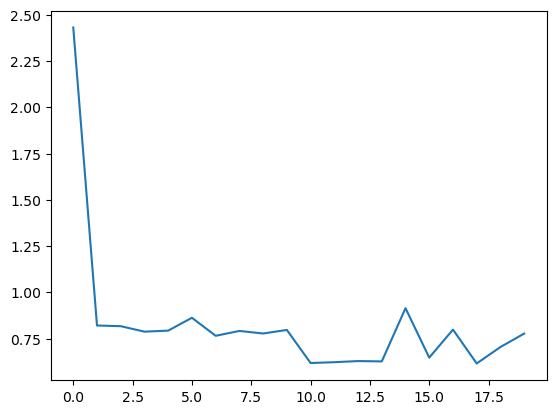

In [13]:
# Plot the model loss function
plt.plot(np.array(losses)[:,1])

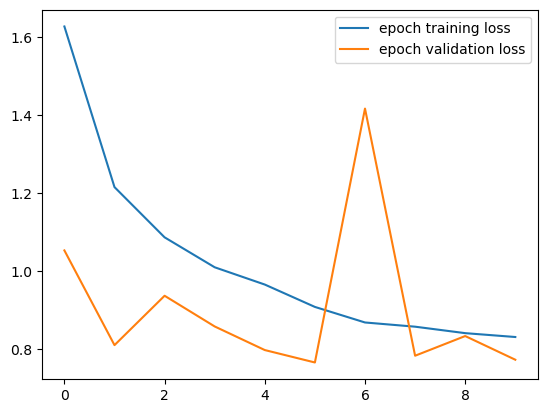

In [14]:
# Epoch training loss
plt.plot(epoch_loss, label='epoch training loss')
plt.plot(val_losses, label='epoch validation loss')
plt.legend()
plt.show()

In [15]:
# Save the model

save_res = True

if save_res:
    # directory
    save_dir = os.path.join(maindir,'data/tabular/mod/dc_data/results/')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(losses)
    model_path = 'dc_planet_ms_ep{}_step{}_b{}.pt'.format(num_epochs, step, bs)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))

    save(model_path)


In [16]:
np.savetxt(os.path.join(save_dir, 'losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(losses))
np.savetxt(os.path.join(save_dir, 'epoch_loss_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(epoch_loss))
np.savetxt(os.path.join(save_dir, 'val_losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(val_losses))

In [26]:
import subprocess

def get_memory_usage():
    try:
        vm_stat = subprocess.check_output(['vm_stat']).decode('utf-8')
        vm_stat_lines = vm_stat.split('\n')
        stats = {}

        for line in vm_stat_lines:
            if line and ':' in line:
                parts = line.split(':')
                if len(parts) == 2 and parts[1].strip().isdigit():
                    key = parts[0].strip()
                    value = int(parts[1].strip().split(' ')[0])
                    stats[key] = value

        page_size = 4096  # macOS uses 4096-byte pages
        free_memory = stats.get('Pages free', 0) * page_size
        used_memory = (stats.get('Pages active', 0) + 
                       stats.get('Pages speculative', 0) + 
                       stats.get('Pages wired down', 0) + 
                       stats.get('Pages occupied by compressor', 0)) * page_size
        total_memory = free_memory + used_memory

        total_memory_mb = total_memory / (1024 ** 2)
        used_memory_mb = used_memory / (1024 ** 2)
        free_memory_mb = free_memory / (1024 ** 2)

        print(f'Total Memory: {total_memory_mb:.2f} MB')
        print(f'Used Memory: {used_memory_mb:.2f} MB')
        print(f'Free Memory: {free_memory_mb:.2f} MB')

    except subprocess.CalledProcessError as e:
        print(f"An error occurred while trying to get memory usage: {e}")

get_memory_usage()

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB


In [28]:
import gc

def get_prediction(m, s):
    res = m(s)
    return res

true_labels = []
pred_labels = []
for idx, sample in enumerate(test_ds):
    
    try:
        if sample['code'] != 255:
            # print(f'on sample {idx} of {len(test_ds)}')
            
            true_labels.append(sample['code'])
                        
            pred_labels.append(get_prediction(model, sample['image'][None,...]).argmax())
            
        else:
            print(f'sample{idx} of {len(test_ds)} had class label 255, skipping...')
        
        if idx%100 == 0:
            # get_memory_usage()
            # pause, gc.collect
            time.sleep(0.3)
            gc.collect()
            # print('after gc.collect()...')
            # get_memory_usage()
            print()
        
    except Exception as e:
        print(e, 'continuing...')

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB
after gc.collect()...
Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB
after gc.collect()...
Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB
after gc.collect()...
Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB
after gc.collect()...
Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB
after gc.collect()...
Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB
after gc.collect()...
Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB

Total Memory: 0.00 MB
Used Memory: 0.00 MB
Free Memory: 0.00 MB
after gc.collect()...
Total Me

In [36]:
# Ensure 'class_code' is of categorical dtype
test_df['class_code'] = test_df['class_code'].astype('category')

# Create the dictionary mapping
cat_dict = dict(enumerate(test_df['class_code'].cat.categories))
print(cat_dict)

{0: 'CS', 1: 'ME', 2: 'SH', 3: 'SL', 4: 'TL', 5: 'UR', 6: 'WS'}


In [38]:
class_codes_numbers = [k for k in cat_dict.keys() if cat_dict[k] in test_df.class_code.unique().to_list()]
class_codes_numbers

[0, 1, 2, 3, 4, 5, 6]

(array([2049., 2019.,    0.,  643.,    0.,   50.,   49.,    0.,   50.,
          37.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

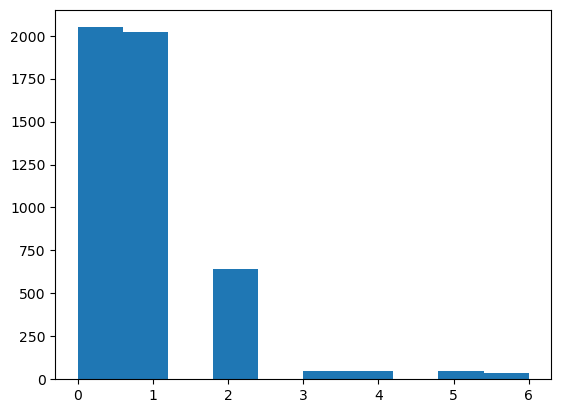

In [39]:
plt.hist(true_labels)

In [40]:
sum(p.numel() for p in model.parameters() if p.requires_grad) # number of trainable model parameters

11217735

In [43]:
cor_label_num = class_codes_numbers
cor_labels = []
for c in cor_label_num:
    cor_labels.append(cat_dict[c])
    
print(cor_labels)

['CS', 'ME', 'SH', 'SL', 'TL', 'UR', 'WS']


In [46]:
cr_df = pd.DataFrame(classification_report(true_labels, pred_labels, target_names=cor_labels, output_dict=True)).transpose()
cr_df

,precision,recall,f1-score,support
CS,0.698241,0.852611,0.767743,2049.000000
ME,0.869944,0.841506,0.855488,2019.000000
SH,0.456471,0.301711,0.363296,643.000000
SL,0.000000,0.000000,0.000000,50.000000
TL,0.588235,0.204082,0.303030,49.000000
UR,0.000000,0.000000,0.000000,50.000000
WS,0.000000,0.000000,0.000000,37.000000
accuracy,0.745354,0.745354,0.745354,0.745354
macro avg,0.373270,0.314273,0.327080,4897.000000
weighted avg,0.716652,0.745354,0.724686,4897.000000


In [49]:
for c in cor_labels:
    print(test_df.loc[test_df['class_code'] == c].shape[0])

2049
2019
37
643
49
50
50


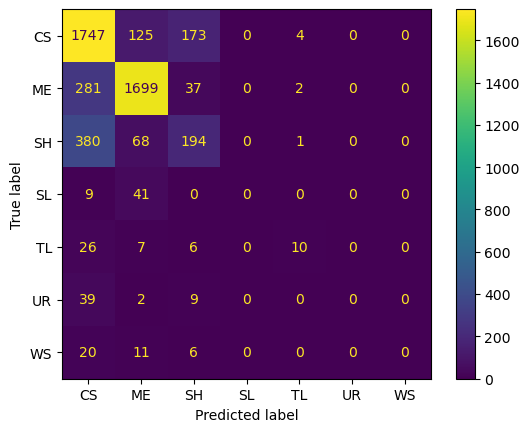

In [50]:
class_label_names = cor_labels # get these smartly somehow... categories got a bit mixed up
class_labels = class_codes_numbers
cm = confusion_matrix(true_labels, pred_labels, labels=cor_label_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label_names)
disp.plot()